In [1]:
# IMPORTS ****************************************************

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage as sk
import skimage.io as skio
import time

In [2]:
# START TIMER ****************************************************

start_time = time.time()

In [3]:
# 1. USER INPUT - (DEFINE MODEL PARAMS) ****************************************************

# a. choose search displacement range (pixels)
search = 35

# b. choose image to colorize
name = "village"

# c. define crop amount (% of overall image width / height)
crop_amount = 5

# d. define image path
img_path = "data/plates_reduced_size/"

In [4]:
# # 2. DEFINE IMAGE PATH ****************************************************

image_choice = f"{name}.tif"
file_name = f"{image_choice}_1"

img_name = image_choice

image_Z = skio.imread(img_path+img_name)

In [5]:
# 3. GET IMAGE DIMENSIONS ****************************************************

# original dimensions
original_height = image_Z.shape[0]
original_width = image_Z.shape[1]

# reduced dimensions
reduc_height = int(original_height / 3)
reduc_width = int(original_width)

In [6]:
# 4. SEPERATE COLOR CHANNEL IMAGES ****************************************************

blue_channel = image_Z[:reduc_height]
green_channel  = image_Z[reduc_height: 2*reduc_height]
red_channel = image_Z[2*reduc_height: 3*reduc_height]

In [7]:
# 5. CROP IMAGE BORDERS ****************************************************

# Set crop amounts per side
crop_height = int(reduc_height * (crop_amount/100))
crop_width = int(reduc_width * (crop_amount/100))

# assign to variables
left_crop = crop_width
right_crop = reduc_width - crop_width
top_crop = crop_height
bottom_crop = reduc_height - crop_height

# crop images
red_channel = red_channel[top_crop:bottom_crop, left_crop:right_crop]
blue_channel = blue_channel[top_crop:bottom_crop, left_crop:right_crop]
green_channel = green_channel[top_crop:bottom_crop, left_crop:right_crop]

In [8]:
# 6. FIND NCC - GREEN CHANNEL ****************************************************

# a. Create list of all shift possibilities
# Cycle through all possible x & y shifts and store in list
axis_shift_list = []

for x_axis in range (-search,search+1):
    for y_axis in range(-search,search+1):
        
        shift = [x_axis, y_axis]
        
        axis_shift_list.append(shift)
        
# b. Create list of shifted image arrays per shift possibilities
# Apply np.roll function to create all shift possibilities
# per https://numpy.org/doc/stable/reference/generated/numpy.roll.html
green_shift_list = []

for shift in axis_shift_list:
    
    green_shift_list.append(np.roll(green_channel, 
                            shift, 
                            axis = (0,1)))
    
# c. Create list of NCC Scores of all shifted images
# Determine which green shift image has the best NCC score when compared to blue_channel image

NCC_scores = []

for green_shift_image in green_shift_list:
    
    # Normalize both green_shift_image & blue_channel image.
    # Per https://www.kite.com/python/answers/how-to-normalize-an-array-in-numpy-in-python
    green_shift_image_norm = np.linalg.norm(green_shift_image)
    blue_channel_norm = np.linalg.norm(blue_channel)
    
    # Returned flattened array
    # per https://numpy.org/doc/stable/reference/generated/numpy.dot.html
    # per https://xcdskd.readthedocs.io/en/latest/cross_correlation/cross_correlation_coefficient.html
    green_shift_1D = np.ravel(green_shift_image)
    blue_channel_1D = np.ravel( blue_channel)
    
    # Find NCC via dot product between the two normalized vectors and add to NCC_scores list
    NCC_scores.append(np.dot(green_shift_1D/green_shift_image_norm, 
                            blue_channel_1D/blue_channel_norm))

# d. Find max score & return corresponding x,y axis
max_NCC = max(NCC_scores)
max_index = NCC_scores.index(max_NCC) 

final_shift = axis_shift_list[max_index]
final_shift_green = axis_shift_list[max_index]

# e. Transform green_channel image to match best shift
green_shift_final = np.roll(green_channel,
                          final_shift,
                          axis = (0,1)) 

In [9]:
# 7. FIND NCC - RED CHANNEL ****************************************************

# a. Create list of all shift possibilities
# Cycle through all possible x & y shifts and store in list
axis_shift_list = []

for x_axis in range (-search,search+1):
    for y_axis in range(-search,search+1):
        
        shift = [x_axis, y_axis]
        
        axis_shift_list.append(shift)
               
# b. Create list of shifted image arrays per shift possibilities
# Apply np.roll function to create all shift possibilities
# per https://numpy.org/doc/stable/reference/generated/numpy.roll.html
red_shift_list = []

for shift in axis_shift_list:
    
    red_shift_list.append(np.roll(red_channel, 
                            shift, 
                            axis = (0,1)))

    
# c. Create list of NCC Scores of all shifted images
# Determine which green shift image has the best NCC score when compared to blue_channel image
NCC_scores = []

for red_shift_image in red_shift_list:
    
    # Normalize both red_shift_image & blue_channel image.
    # Per https://www.kite.com/python/answers/how-to-normalize-an-array-in-numpy-in-python
    red_shift_image_norm = np.linalg.norm(red_shift_image)
    blue_channel_norm = np.linalg.norm(blue_channel)
    
    # Returned flattened array
    # per https://numpy.org/doc/stable/reference/generated/numpy.dot.html
    # per https://xcdskd.readthedocs.io/en/latest/cross_correlation/cross_correlation_coefficient.html   
    red_shift_1D = np.ravel(red_shift_image)
    blue_channel_1D = np.ravel(blue_channel)
    
    # Find NCC via dot product between the two normalized vectors and add to NCC_scores list
    NCC_scores.append(np.dot(red_shift_1D/red_shift_image_norm, 
                            blue_channel_1D/blue_channel_norm))
    
# d. Find max score & return corresponding x,y axis
max_NCC = max(NCC_scores)
max_index = NCC_scores.index(max_NCC) 

final_shift = axis_shift_list[max_index]
final_shift_red = axis_shift_list[max_index]

# e. Transform green_channel image to match best shift
red_shift_final = np.roll(red_channel,
                          final_shift,
                          axis = (0,1)) 

In [10]:
# 8. STACK IMAGES ****************************************************
im_out = np.dstack((red_shift_final, green_shift_final, blue_channel))

In [11]:
# 9. SAVE IMAGE ****************************************************
fname = f'{name}_NCC_Test_{search}.jpg'
skio.imsave(fname, im_out)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.


In [12]:
# END TIMER ****************************************************

end_time = time.time()

total_time =(end_time - start_time)

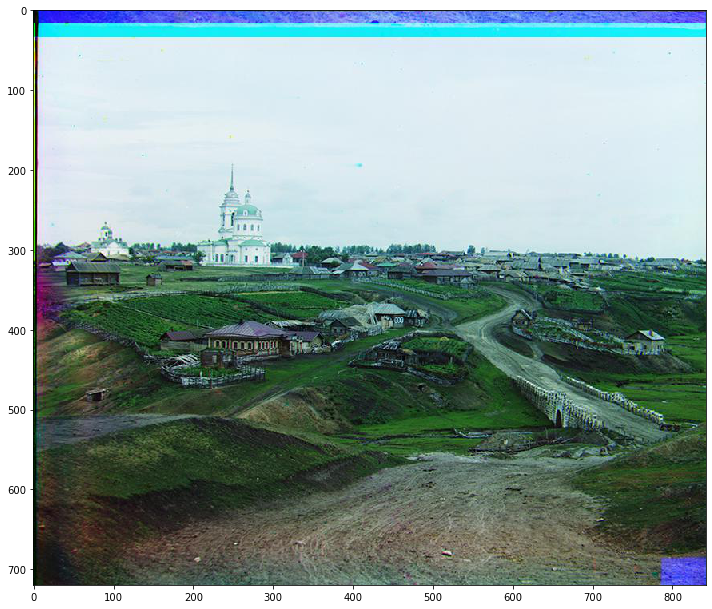

total time = 66.56260824203491 seconds
red channel shift = [34, 5]
green channel shift = [16, 3]


In [13]:
# 10. DISPLAY IMAGE, TOTAL TIME, RED & GREEN CHANNEL SHIFTS ****************************************************

plt.figure(figsize = (10,10))
skio.imshow(fname)
skio.show()

print(f'total time = {total_time} seconds')
print(f'red channel shift = {final_shift_red}')
print(f'green channel shift = {final_shift_green}')